# Data preprocessing

## Imports

In [1]:
import os
import pickle
from datetime import timedelta

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from tqdm import tqdm

## Data analysis

In [15]:
SAVING_DIR = os.path.join('data', 'new_data')
DATA_PATH = os.path.join('data', 'new_data', 'transactions.parquet')

In [14]:
df_transactions = pd.read_parquet(DATA_PATH)
df_transactions.head(5)

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,000932580e404dafbecd5916d4640938,5411,48,-361.07230,2020-08-03 08:05:23
1,000932580e404dafbecd5916d4640938,5499,48,-137.31398,2020-08-05 01:27:40
2,000932580e404dafbecd5916d4640938,5499,48,-138.84981,2020-08-05 03:28:11
3,000932580e404dafbecd5916d4640938,4829,48,-309.47653,2020-08-06 00:36:29
4,000932580e404dafbecd5916d4640938,5411,48,-133.47370,2020-08-09 00:30:13


Text(0, 0.5, 'Frequency')

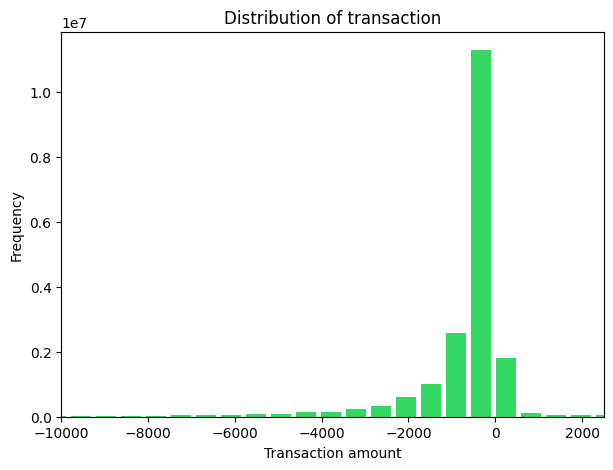

In [6]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

x = df_transactions['transaction_amt'].values

hist, bins = np.histogram(x, bins=1000)

freq = 10000 #500

hist[np.where(hist <= freq)] = 0

width = 0.8 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.xlim([-10000, 2500])
plt.bar(center, hist, align='center', width=width, color = '#33D860', label='normal')#'#7eb54e')
plt.title("Distribution of transaction")
plt.xlabel("Transaction amount")
plt.ylabel("Frequency");

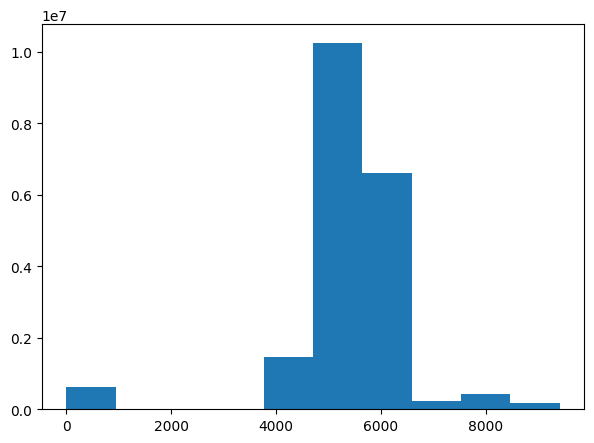

In [7]:
plt.hist(df_transactions['mcc_code']);

In [8]:
df_transactions['currency_rk'].value_counts()

 48    19765158
-1        27405
 50       20364
 60        8983
Name: currency_rk, dtype: int64

In [9]:
df_transactions[(df_transactions['transaction_amt'] > 0)]['mcc_code'].value_counts()

-1       589319
 4829    217710
 6012     34121
 6011     31694
 5691     16686
          ...  
 9406         1
 3770         1
 7393         1
 3366         1
 8241         1
Name: mcc_code, Length: 262, dtype: int64

In [10]:
df_transactions[df_transactions['mcc_code'] == -1].count()

user_id             623291
mcc_code            623291
currency_rk         623291
transaction_amt     623291
transaction_dttm    623291
dtype: int64

## Data preprocessing

### Creation of the sequences

In [11]:
data_srt = df_transactions.sort_values(['user_id','transaction_dttm']).reset_index()
data_srt.head(10)

,index,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,0,000932580e404dafbecd5916d4640938,5411,48,-361.072300,2020-08-03 08:05:23
1,1,000932580e404dafbecd5916d4640938,5499,48,-137.313980,2020-08-05 01:27:40
2,2,000932580e404dafbecd5916d4640938,5499,48,-138.849810,2020-08-05 03:28:11
3,3,000932580e404dafbecd5916d4640938,4829,48,-309.476530,2020-08-06 00:36:29
4,4,000932580e404dafbecd5916d4640938,5411,48,-133.473700,2020-08-09 00:30:13
5,5,000932580e404dafbecd5916d4640938,5814,48,-63.414547,2020-08-09 01:18:28
6,6,000932580e404dafbecd5916d4640938,4789,48,-1640.281600,2020-08-09 23:43:24
7,7,000932580e404dafbecd5916d4640938,5411,48,-1497.890500,2020-08-10 03:26:58
8,8,000932580e404dafbecd5916d4640938,5814,48,-177.117340,2020-08-24 19:28:46
9,9,000932580e404dafbecd5916d4640938,5411,48,-95.083080,2020-08-27 01:46:31


In [ ]:
start_user = data_srt.iloc[0]['user_id']
new_col = []
index = 0
start_time = data_srt.iloc[0]['transaction_dttm']
count = 0

for i in tqdm(range(len(data_srt))):
    cur_date = data_srt.iloc[i]['transaction_dttm']
    cur_user = data_srt.iloc[i]['user_id']
    count += 1
    if ((pd.to_datetime(cur_date)>pd.to_datetime(start_time)+timedelta(days=7))&(count>40))or(cur_user!=start_user): #suppose data is sorted
        count = 1
        index+=1
        start_time = cur_date #one_user.iloc[i]['transaction_dttm']
        start_user = cur_user
    new_col.append(index)

100%|██████████| 19821910/19821910 [1:10:21<00:00, 4694.93it/s]


In [ ]:
data_srt['sample_label'] = pd.DataFrame(new_col)

data_srt['count'] = data_srt.groupby('sample_label')['sample_label'].transform('count')
data_srt = data_srt[(data_srt['count'] >= 40) & (data_srt['count'] <= 120)]
data_srt.drop(columns=['count'], inplace=True)

# Additional saving. Comment if there is no need for this.
# data_srt.to_parquet(os.path.join(SAVING_DIR, 'labeled_sequences.parquet'))

In [ ]:
# Needed for embedding layer in the model.
# Kind of hardcode, will be modified in the future.
compare_table = {}
start = 1

for mcc in data_srt['mcc_code'].unique():
    compare_table[mcc] = start
    start += 1

with open('compare_table', 'wb') as f:
    f.write(pickle.dumps(compare_table))

### Anomaly defenition

In [15]:
data_srt['anomaly'] = 0

In [117]:
def check_by_quantiles(data: pd.DataFrame):
    for mcc in tqdm(data['mcc_code'].unique()):
        pos_pos = data[(data['mcc_code'] == mcc) & (data['transaction_amt'] > 0)]['transaction_amt'].quantile(.99)
        pos_neg = data[(data['mcc_code'] == mcc) & (data['transaction_amt'] < 0)]['transaction_amt'].quantile(.1)

        answ = data[data['mcc_code'] == mcc]['transaction_amt'].apply(lambda x: int(x > pos_pos or x < pos_neg))
        data.loc[answ.index, 'anomaly'] = answ

In [119]:
check_by_quantiles()

print(f"Num of the anomalies - {data_srt['anomaly'].sum()}")

100%|██████████| 386/386 [01:53<00:00,  3.41it/s]


## Data splitting

In [ ]:
transactions_neg_scaled = StandardScaler().fit_transform(
    data_srt[data_srt['transaction_amt'] < 0]['transaction_amt'].to_numpy().reshape(-1, 1))
transactions_pos_scaled = StandardScaler().fit_transform(
    data_srt[data_srt['transaction_amt'] >= 0]['transaction_amt'].to_numpy().reshape(-1, 1))

In [ ]:
data_srt['transaction_amt_scaled'] = 0
data_srt.loc[data_srt['transaction_amt'] < 0, 'transaction_amt_scaled'] = transactions_neg_scaled
data_srt.loc[data_srt['transaction_amt'] >= 0, 'transaction_amt_scaled'] = transactions_pos_scaled

In [ ]:
sums = data_srt.groupby(['sample_label'])['anomaly'].sum()
anomaly_count = 0
normal_count = 0

if not os.path.exists(os.path.join('SAVING_DIR', 'anomaly')):
    os.mkdir(os.path.join('SAVING_DIR', 'anomaly'))

if not os.path.exists(os.path.join('SAVING_DIR', 'normal')):
    os.mkdir(os.path.join('SAVING_DIR', 'normal'))

for label in tqdm(data_srt['sample_label'].unique()):
    seq = data_srt[data_srt['sample_label'] == label][['user_id', 'mcc_code', 'transaction_amt_scaled', 'transaction_dttm']]
    anchor = pd.to_datetime(seq.iloc[0]['transaction_dttm'])
    seq['time'] = seq['transaction_dttm'].apply(lambda x: int((pd.to_datetime(x) - anchor).total_seconds()))
    seq.drop(columns=['transaction_dttm'], inplace=True)
    seq.rename(columns={'mcc_code': 'mcc', 'transaction_amt_scaled': 'amt'}, inplace=True)

    if sums.loc[label] > 0:
        seq.to_csv(os.path.join(SAVING_DIR, 'anomaly', f'{anomaly_count}.csv'), index=False)
        anomaly_count += 1
    else:
        seq.to_csv(os.path.join(SAVING_DIR, 'normal', f'{normal_count}.csv'), index=False)
        normal_count += 1

print(f'Anomaly samples - {anomaly_count}\nNormal samples - {normal_count}')

In [ ]:
pd.read_csv('data/new_data/anomaly/0.csv')